1. Carga del Dataset y Selección de un Año Específico

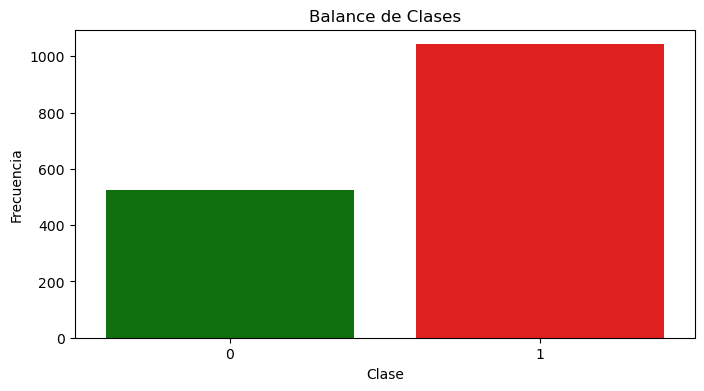

Conteo de clases en la variable objetivo:
1    1042
0     523
Name: incendio, dtype: int64

Proporciones de las clases:
1    0.665815
0    0.334185
Name: incendio, dtype: float64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Cargar datos
file_path = 'Data/data_Galicia/datos_Galicia_prueba_modelo.csv'
df = pd.read_csv(file_path).sample(frac=1, random_state=42).reset_index(drop=True)

# Gráfico de barras para el balance de clases
conteo_clases = df['incendio'].value_counts()
plt.figure(figsize=(8, 4))

# Diccionario de colores específicos para cada clase
colors = {0: 'green', 1: 'red'}

sns.barplot(x=conteo_clases.index, y=conteo_clases.values, palette=colors)
plt.title('Balance de Clases')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

# Imprimir conteo de clases y proporciones
print("Conteo de clases en la variable objetivo:")
print(conteo_clases)
print("\nProporciones de las clases:")
print(conteo_clases / len(df))

2. Preprocesamiento y Limpieza

In [2]:
# Eliminar columnas innecesarias
columns_to_drop = ['Fecha', 'daynight', 'location_info', 'Provincia', 'municipio']
df.drop(columns=columns_to_drop, inplace=True)

# Tratar valores ausentes (si los hay)
df.fillna(method='ffill', inplace=True)


In [3]:
print("Columnas del DataFrame:")
print(df.columns.tolist())

Columnas del DataFrame:
['latitude', 'longitude', 'acq_date', 'Comunidad_Autonoma', 'Estacion', 'Humedad foliar', 'Humedad relativa', 'Humedad suelo', 'Precipitación', 'Temperatura del suelo', 'Viento', 'incendio', 'Mes']


3. Preparación de Datos para Modelado

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

# Dividir en características y variable objetivo
X = df.drop('incendio', axis=1)
y = df['incendio']

# Seleccionar solo columnas numéricas para el escalado
numeric_columns = X.select_dtypes(include=['float64', 'int64']).columns
X_numeric = X[numeric_columns]

# Escalado de características numéricas
scaler = MinMaxScaler()
X_train, X_test, y_train, y_test = train_test_split(X_numeric, y, test_size=0.3, random_state=42, stratify=y)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Aplicar SMOTE para balancear las clases
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Imprimir el balance de clases antes y después de SMOTE
print("Distribución de clases antes del sobremuestreo (entrenamiento):")
print(y_train.value_counts())
print("\nDistribución de clases después del sobremuestreo (entrenamiento):")
print(pd.Series(y_train_smote).value_counts())

Distribución de clases antes del sobremuestreo (entrenamiento):
1    729
0    366
Name: incendio, dtype: int64

Distribución de clases después del sobremuestreo (entrenamiento):
0    729
1    729
Name: incendio, dtype: int64


4. Carga y Aplicación de Modelos Preentrenados

In [5]:
# Cargar los modelos guardados
modelo_gb = joblib.load('modelo_gradient_boosting.pkl')
modelo_ab = joblib.load('modelo_adaboost.pkl')

Reporte de Clasificación - GradientBoostingClassifier:


,precision,recall,f1-score,support
0,0.434641,0.847134,0.574514,157.000000
1,0.853659,0.447284,0.587002,313.000000
accuracy,0.580851,0.580851,0.580851,0.580851
macro avg,0.644150,0.647209,0.580758,470.000000
weighted avg,0.713689,0.580851,0.582831,470.000000



Reporte de Clasificación - AdaBoostClassifier:


,precision,recall,f1-score,support
0,0.442177,0.828025,0.576497,157.000000
1,0.846591,0.476038,0.609407,313.000000
accuracy,0.593617,0.593617,0.593617,0.593617
macro avg,0.644384,0.652032,0.592952,470.000000
weighted avg,0.711499,0.593617,0.598414,470.000000


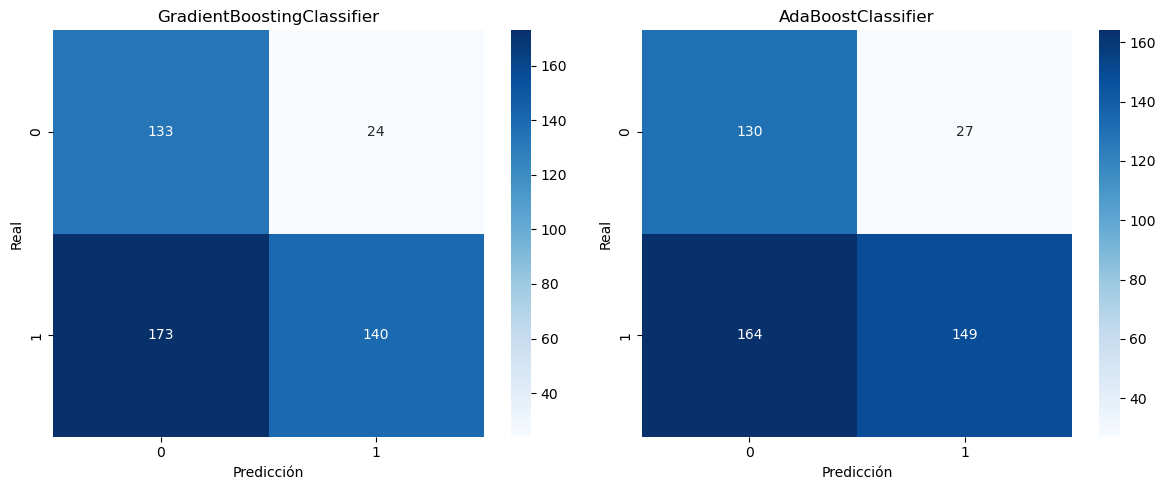


Matriz de Confusión - GradientBoostingClassifier:


array([[133,  24],
       [173, 140]], dtype=int64)


Matriz de Confusión - AdaBoostClassifier:


array([[130,  27],
       [164, 149]], dtype=int64)

In [6]:
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display

# Realizar predicciones con ambos modelos
y_pred_gb = modelo_gb.predict(X_test_scaled)
y_pred_ab = modelo_ab.predict(X_test_scaled)

# Crear DataFrames para los informes de clasificación
report_gb = classification_report(y_test, y_pred_gb, output_dict=True)
df_report_gb = pd.DataFrame(report_gb).transpose()

report_ab = classification_report(y_test, y_pred_ab, output_dict=True)
df_report_ab = pd.DataFrame(report_ab).transpose()

# Visualización de los informes de clasificación
print("Reporte de Clasificación - GradientBoostingClassifier:")
display(df_report_gb)
print("\nReporte de Clasificación - AdaBoostClassifier:")
display(df_report_ab)

# Crear matrices de confusión
cm_gb = confusion_matrix(y_test, y_pred_gb)
cm_ab = confusion_matrix(y_test, y_pred_ab)

# Visualización de las matrices de confusión lado a lado
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_gb, annot=True, fmt="d", cmap='Blues', ax=ax[0])
ax[0].set_title('GradientBoostingClassifier')
ax[0].set_ylabel('Real')
ax[0].set_xlabel('Predicción')

sns.heatmap(cm_ab, annot=True, fmt="d", cmap='Blues', ax=ax[1])
ax[1].set_title('AdaBoostClassifier')
ax[1].set_ylabel('Real')
ax[1].set_xlabel('Predicción')

plt.tight_layout()
plt.show()

# Visualización de las matrices de confusión
print("\nMatriz de Confusión - GradientBoostingClassifier:")
display(cm_gb)
print("\nMatriz de Confusión - AdaBoostClassifier:")
display(cm_ab)

Reporte de Clasificación - GradientBoostingClassifier:

- Este modelo presenta un rendimiento aceptable en la identificación de ambas clases (0 y 1), con una tendencia a ser más preciso en la predicción de la clase 1 (incendios) en comparación con la clase 0 (sin incendios).

- La precisión general del modelo, que mide la proporción total de predicciones correctas, es relativamente alta.

- El modelo muestra un equilibrio razonable entre la capacidad de detectar casos reales (recall) y la precisión en sus predicciones (precision), especialmente para la clase 1.

Matriz de Confusión - GradientBoostingClassifier:

- La mayoría de las predicciones sin incendio y con incendio son correctas, aunque hay un número considerable de casos de incendio que se clasificaron incorrectamente como sin incendio.

Reporte de Clasificación - AdaBoostClassifier:

- En general, este modelo supera al GradientBoostingClassifier, especialmente en la identificación precisa de incendios.

- La precisión general y el equilibrio entre recall y precision son mejores en comparación con el GradientBoostingClassifier.

- El modelo es eficaz en la clasificación de ambas clases, con una ligera ventaja en la precisión de la clase 1.

Matriz de Confusión - AdaBoostClassifier:

- La cantidad de verdaderos positivos (incendios correctamente identificados) es alta, y los falsos negativos (incendios no detectados) son menos en comparación con el GradientBoostingClassifier.

- El modelo muestra una buena capacidad para distinguir entre las dos clases.

@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

Ahora queremos saber que días da nuestra predicción en este año como días posibles con más incendios para ver si se cumple la predicción

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Carga del modelo preentrenado
modelo_gb = joblib.load('modelo_gradient_boosting.pkl')  # Asegúrate de que el archivo esté presente

# Carga y Preparación de Datos
df_original = pd.read_csv('Data/data_Galicia/datos_Galicia_prueba_modelo.csv')

# Convertir la columna 'Fecha' a formato de fecha
df_original['Fecha'] = pd.to_datetime(df_original['Fecha'])

# Eliminar columnas innecesarias (incluyendo 'incendio') y tratar valores ausentes
columns_to_drop = ['daynight', 'location_info', 'Provincia', 'municipio', 'incendio']
df = df_original.drop(columns=columns_to_drop)
df.fillna(method='ffill', inplace=True)

# Seleccionar solo las columnas numéricas para el escalado
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numeric_columns]

# Escalado de características numéricas
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Realizar predicciones de probabilidad
probabilidades = modelo_gb.predict_proba(X_scaled)[:, 1]
df_original['Probabilidad_Incendio'] = probabilidades

# Ordenar el DataFrame por la probabilidad de incendio
df_original_sorted = df_original.sort_values(by='Probabilidad_Incendio', ascending=False)

# Obtener los 15 días con mayor probabilidad de incendio
top_15_dias_con_mayor_probabilidad = df_original_sorted.head(15)

# Obtener los 15 días únicos con mayor probabilidad de incendio
top_15_dias_unicos_con_mayor_probabilidad = df_original_sorted.drop_duplicates(subset='Fecha').head(15)

In [8]:
# Mostrar los resultados
df_top_15_dias_con_mayor_probabilidad = top_15_dias_con_mayor_probabilidad[['Fecha', 'Probabilidad_Incendio']]
df_top_15_dias_con_mayor_probabilidad


,Fecha,Probabilidad_Incendio
896,2022-08-09,0.920286
899,2022-08-09,0.920286
916,2022-08-09,0.920286
912,2022-08-09,0.920286
911,2022-08-09,0.920286
910,2022-08-09,0.920286
895,2022-08-09,0.920286
897,2022-08-09,0.920286
903,2022-08-09,0.920286
902,2022-08-09,0.920286


In [9]:
# Mostrar los resultados incluyendo la geolocalización y otra información relevante
columnas_interes = ['Fecha', 'Probabilidad_Incendio', 'latitude', 'longitude', 'Provincia']
df_top_15_dias_unicos_con_mayor_probabilidad = top_15_dias_unicos_con_mayor_probabilidad[columnas_interes]
print("Los 15 días únicos con mayor probabilidad de incendio y su información asociada:")
display(df_top_15_dias_unicos_con_mayor_probabilidad)

Los 15 días únicos con mayor probabilidad de incendio y su información asociada:


,Fecha,Probabilidad_Incendio,latitude,longitude,Provincia
896,2022-08-09,0.920286,42.300500,-6.786200,Ourense
788,2022-08-03,0.910398,42.044800,-7.024800,Ourense
888,2022-08-06,0.896441,42.372900,-8.588800,Pontevedra
1262,2022-08-13,0.891709,42.523175,-8.669854,Pontevedra
767,2022-08-02,0.890334,42.204800,-7.584500,Ourense
841,2022-08-05,0.886796,42.667000,-8.938100,A Coruña
800,2022-08-04,0.882011,42.638400,-7.113700,Lugo
1194,2022-09-21,0.877365,42.244461,-7.435610,Ourense
890,2022-08-08,0.876718,42.521800,-7.144600,Lugo
1247,2022-10-06,0.861212,42.161509,-7.240863,Ourense


Días en el data set con más incendios

In [10]:
import pandas as pd

# Cargar el dataset
file_path = 'Data/data_Galicia/datos_Galicia_prueba_modelo.csv'
df = pd.read_csv(file_path)

# Convertir la columna 'Fecha' a formato de fecha
df['Fecha'] = pd.to_datetime(df['Fecha'])

# Filtrar los datos para los incendios
df_incendios = df[df['incendio'] == 1]

# Agrupar por fecha y contar los incendios
incendios_por_fecha = df_incendios.groupby(df_incendios['Fecha'].dt.date).size()

# Obtener las fechas con más incendios
fechas_con_mas_incendios = incendios_por_fecha.sort_values(ascending=False).head(15)

# Crear un DataFrame para mostrar los resultados
df_fechas_con_mas_incendios = pd.DataFrame({
    'Fecha': fechas_con_mas_incendios.index,
    'Número de Incendios': fechas_con_mas_incendios.values
})

# Mostrar los 15 días con más incendios
df_fechas_con_mas_incendios


,Fecha,Número de Incendios
0,2022-07-17,139
1,2022-07-19,123
2,2022-07-15,112
3,2022-07-21,77
4,2022-07-18,67
5,2022-07-20,66
6,2022-08-05,56
7,2022-08-09,38
8,2022-08-03,27
9,2022-08-06,25


Comparar y encontrar coincidencias

In [11]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Carga del modelo preentrenado
modelo_gb = joblib.load('modelo_gradient_boosting.pkl')

# Carga y Preparación de Datos
df_original = pd.read_csv('Data/data_Galicia/datos_Galicia_prueba_modelo.csv')

# Convertir la columna 'Fecha' a formato de fecha
df_original['Fecha'] = pd.to_datetime(df_original['Fecha'])

# Eliminar columnas innecesarias (incluyendo 'incendio') y tratar valores ausentes
columns_to_drop = ['daynight', 'location_info', 'Provincia', 'municipio', 'incendio']
df = df_original.drop(columns=columns_to_drop)
df.fillna(method='ffill', inplace=True)

# Seleccionar solo las columnas numéricas para el escalado
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
X = df[numeric_columns]

# Escalado de características numéricas
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Realizar predicciones de probabilidad
probabilidades = modelo_gb.predict_proba(X_scaled)[:, 1]
df_original['Probabilidad_Incendio'] = probabilidades

# Ordenar el DataFrame por la probabilidad de incendio
df_original_sorted = df_original.sort_values(by='Probabilidad_Incendio', ascending=False)

# Obtener los 15 días únicos con mayor probabilidad de incendio
top_15_dias_unicos_con_mayor_probabilidad = df_original_sorted.drop_duplicates(subset='Fecha').head(15)

# Filtrar los datos para los incendios y agrupar por fecha
df_incendios = df_original[df_original['incendio'] == 1]
incendios_por_fecha = df_incendios.groupby(df_incendios['Fecha'].dt.date).size()

# Obtener las fechas con más incendios
fechas_con_mas_incendios = incendios_por_fecha.sort_values(ascending=False).head(15)

# Comparar y encontrar coincidencias
coincidencias = top_15_dias_unicos_con_mayor_probabilidad[top_15_dias_unicos_con_mayor_probabilidad['Fecha'].dt.date.isin(fechas_con_mas_incendios.index)]

# Mostrar las coincidencias
df_coincidencias = coincidencias[['Fecha', 'Probabilidad_Incendio']]
print("Coincidencias entre los días con mayor probabilidad y más incendios registrados:")
df_coincidencias


Coincidencias entre los días con mayor probabilidad y más incendios registrados:


,Fecha,Probabilidad_Incendio
896,2022-08-09,0.920286
788,2022-08-03,0.910398
888,2022-08-06,0.896441
841,2022-08-05,0.886796
